In [1]:
# Force garbage collection
import gc
gc.collect()

41

In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve
import itertools
from sklearn.metrics import precision_recall_curve,auc
from sklearn.metrics import average_precision_score
import warnings

In [3]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [4]:
mod_data = pd.read_parquet(f'../../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_2001_2020.parquet')

In [7]:
mod_data['IS_FIRE'].value_counts()

IS_FIRE
0    15183400
1      151834
Name: count, dtype: int64

In [44]:
# only keep the fire data
mod_Fire = mod_data[mod_data['IS_FIRE'] == 1]

In [52]:
# check percentile of min_FIRE_SIZE
mod_Fire['min_FIRE_SIZE'].describe()

count    151834.000000
mean         95.064986
std        3203.621205
min           0.001000
25%           0.100000
50%           0.200000
75%           1.000000
max      396624.000000
Name: min_FIRE_SIZE, dtype: float64

In [46]:
# check the missing rate of each column
missing_rate = mod_Fire.isnull().mean()
# order the missing rate
missing_rate = missing_rate.sort_values(ascending=False)
missing_rate

LAI                                          0.009583
wind_direction_category                      0.002641
wind_from_direction                          0.002641
pdsi_class                                   0.002167
max_wind_speed                               0.002127
wind_speed                                   0.001824
surface_downwelling_shortwave_flux_in_air    0.001824
specific_humidity                            0.001824
min_relative_humidity                        0.001824
max_relative_humidity                        0.001824
dead_fuel_moisture_100hr                     0.001824
dead_fuel_moisture_1000hr                    0.001824
pdsi_pre_interpolated                        0.000342
pdsi                                         0.000342
slope_max                                    0.000000
min_FIRE_SIZE                                0.000000
slope_avg                                    0.000000
road_density_km_km2                          0.000000
veg                         

In [6]:
mod_data['Year'] = mod_data['day'].dt.year
mod_data['Month'] = mod_data['day'].dt.month

In [20]:
# for each year, month, calculate sum of IS_FIRE and mean of IS_FIRE, save as a df
def get_monthly_fire_data(mod_data):
    monthly_fire_data = mod_data.groupby(['Year', 'Month']).agg({'IS_FIRE': ['sum', 'mean']}).reset_index()
    monthly_fire_data.columns = ['Year', 'Month', 'IS_FIRE_sum', 'IS_FIRE_mean']
    return monthly_fire_data

monthly_fire_data = get_monthly_fire_data(mod_data)

In [21]:
# filter Year >= 2017
monthly_fire_data = monthly_fire_data[monthly_fire_data['Year'] >= 2007]

In [22]:
monthly_fire_data.shape

(168, 4)

In [10]:
# Define the range of years
years = range(2007, 2021)

result_raw = pd.DataFrame()

for year in tqdm(years, desc="Processing years"):
    Eval_data = pd.read_parquet(f'../../Clean_Data/Model_Data/Evaluation/Features_w_Label/{year}_features_w_label.parquet')
    # add Year and Month columns
    Eval_data['Year'] = Eval_data['day'].dt.year
    Eval_data['Month'] = Eval_data['day'].dt.month
    # get monthly fire data
    monthly_fire_data = get_monthly_fire_data(Eval_data)
    # merge with result_raw
    result_raw = pd.concat([result_raw, monthly_fire_data], ignore_index=True)
    gc.collect()

Processing years: 100%|██████████| 14/14 [00:34<00:00,  2.49s/it]


In [17]:
result_raw

,Year,Month,IS_FIRE_sum_raw,IS_FIRE_mean_raw
0,2007,1,560,0.001043
1,2007,2,283,0.000582
2,2007,3,482,0.000897
3,2007,4,650,0.001255
4,2007,5,1349,0.002555
...,...,...,...,...
163,2020,8,1300,0.002479
164,2020,9,710,0.001381
165,2020,10,662,0.001242
166,2020,11,451,0.000871


In [ ]:
# rename columns to be Year, Month, IS_FIRE_sum_raw, IS_FIRE_mean_raw
result_raw.columns = ['Year', 'Month', 'IS_FIRE_sum_raw', 'IS_FIRE_mean_raw']

In [23]:
result_raw.shape

(168, 4)

In [31]:
# merge with monthly_fire_data
merge_data = pd.merge(monthly_fire_data, result_raw, on=['Year', 'Month'], how='inner')

In [32]:
merge_data.shape

(168, 6)

In [33]:
merge_data

,Year,Month,IS_FIRE_sum,IS_FIRE_mean,IS_FIRE_sum_raw,IS_FIRE_mean_raw
0,2007,1,560,0.008608,560,0.001043
1,2007,2,283,0.004824,283,0.000582
2,2007,3,482,0.007412,482,0.000897
3,2007,4,650,0.010389,650,0.001255
4,2007,5,1349,0.020842,1349,0.002555
...,...,...,...,...,...,...
163,2020,8,1300,0.020239,1300,0.002479
164,2020,9,710,0.011375,710,0.001381
165,2020,10,662,0.010275,662,0.001242
166,2020,11,451,0.007210,451,0.000871


In [34]:
# check if column IS_FIRE_sum_raw is equal to IS_FIRE_sum
merge_data['IS_FIRE_sum_raw'].equals(merge_data['IS_FIRE_sum'])

True

In [35]:
# DROP IS_FIRE_sum_raw
merge_data = merge_data.drop(columns=['IS_FIRE_sum_raw'])

In [36]:
merge_data

,Year,Month,IS_FIRE_sum,IS_FIRE_mean,IS_FIRE_mean_raw
0,2007,1,560,0.008608,0.001043
1,2007,2,283,0.004824,0.000582
2,2007,3,482,0.007412,0.000897
3,2007,4,650,0.010389,0.001255
4,2007,5,1349,0.020842,0.002555
...,...,...,...,...,...
163,2020,8,1300,0.020239,0.002479
164,2020,9,710,0.011375,0.001381
165,2020,10,662,0.010275,0.001242
166,2020,11,451,0.007210,0.000871


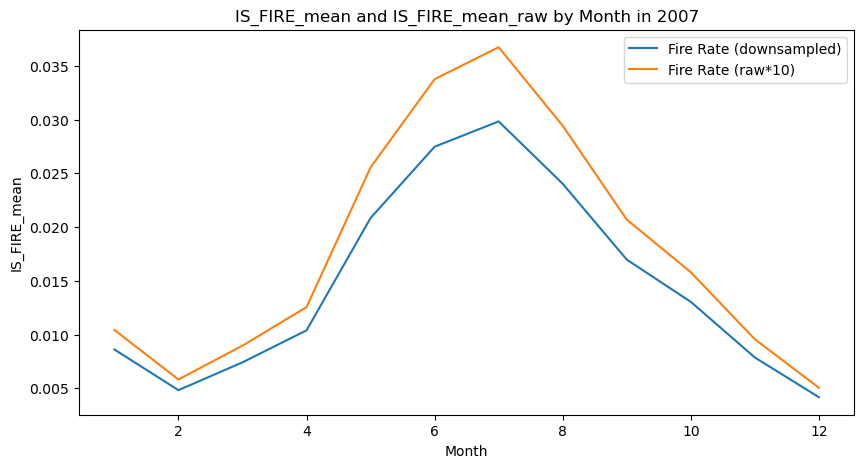

In [40]:
# when year = 2007, plot IS_FIRE_mean and IS_FIRE_mean_raw by month
plt.figure(figsize=(10, 5))
plt.plot(merge_data[merge_data['Year'] == 2007]['Month'], merge_data[merge_data['Year'] == 2007]['IS_FIRE_mean'], label='IS_FIRE_mean')
plt.plot(merge_data[merge_data['Year'] == 2007]['Month'], merge_data[merge_data['Year'] == 2007]['IS_FIRE_mean_raw']*10, label='IS_FIRE_mean_raw')
plt.xlabel('Month')
plt.ylabel('IS_FIRE_mean')
plt.title('IS_FIRE_mean and IS_FIRE_mean_raw by Month in 2007')
# change legend label to 'Fire Rate' and 'Fire Rate Raw'
plt.legend(['Fire Rate (downsampled)', 'Fire Rate (raw*10)'])
plt.show()

In [42]:
def plot_fire_data(merge_data, year):
    plt.figure(figsize=(10, 5))
    plt.plot(merge_data[merge_data['Year'] == year]['Month'], merge_data[merge_data['Year'] == year]['IS_FIRE_mean'], label='IS_FIRE_mean')
    plt.plot(merge_data[merge_data['Year'] == year]['Month'], merge_data[merge_data['Year'] == year]['IS_FIRE_mean_raw']*10, label='IS_FIRE_mean_raw')
    plt.xlabel('Month')
    plt.ylabel('IS_FIRE_mean')
    plt.title(f'IS_FIRE_mean and IS_FIRE_mean_raw by Month in {year}')
    plt.legend(['Fire Rate (downsampled)', 'Fire Rate (raw*10)'])
    # save the figure
    plt.savefig(f'../../Plot/Fire_Rate/{year}_IS_FIRE_mean.png')

Processing years: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]


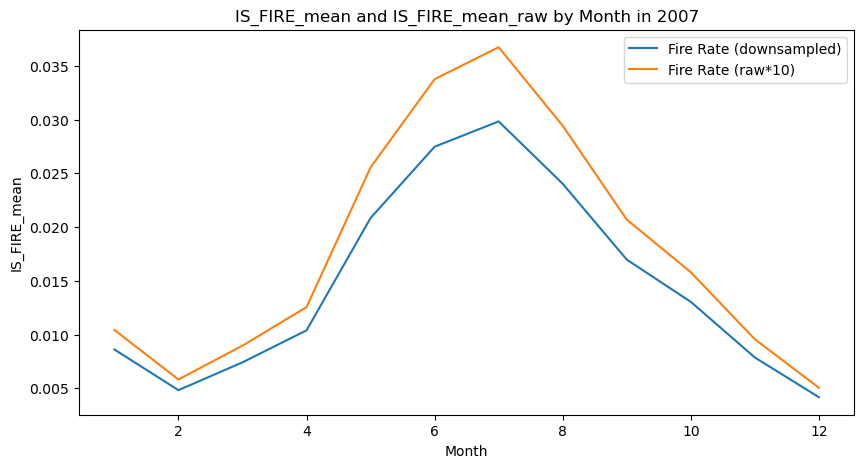

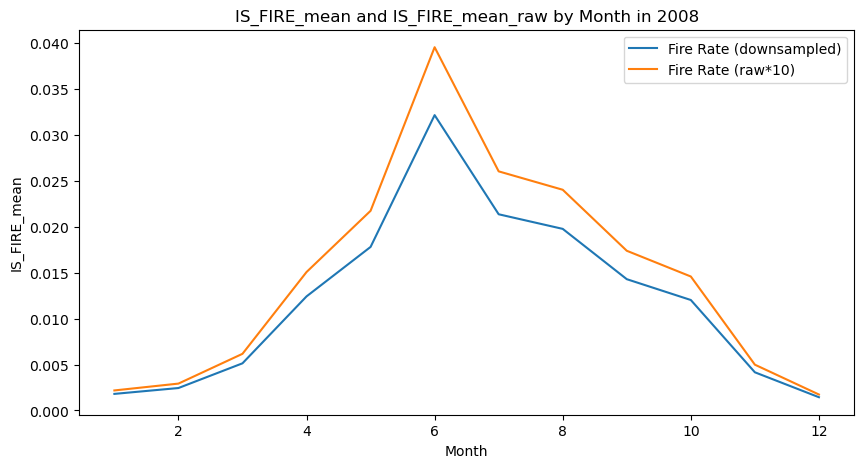

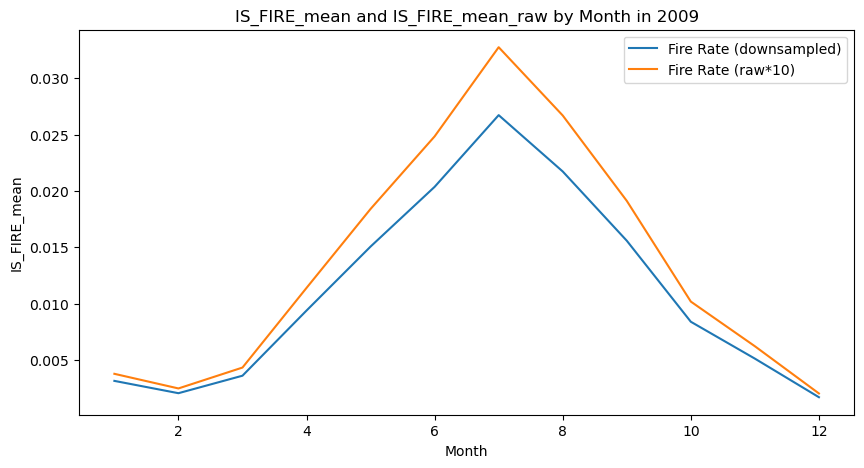

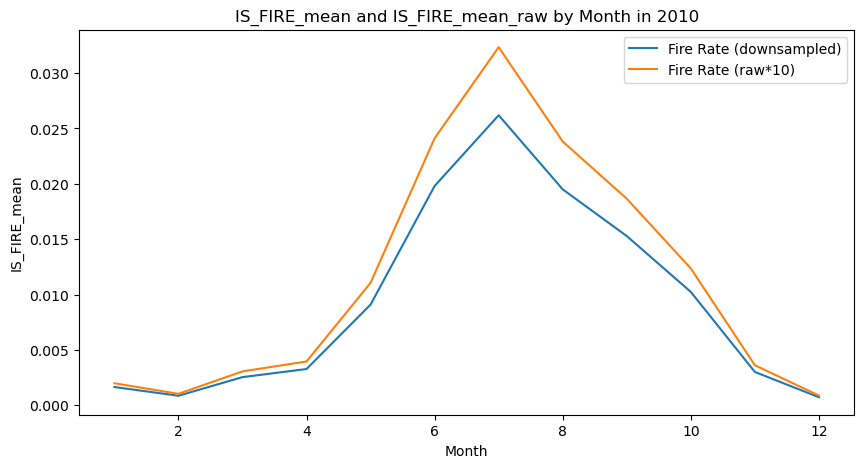

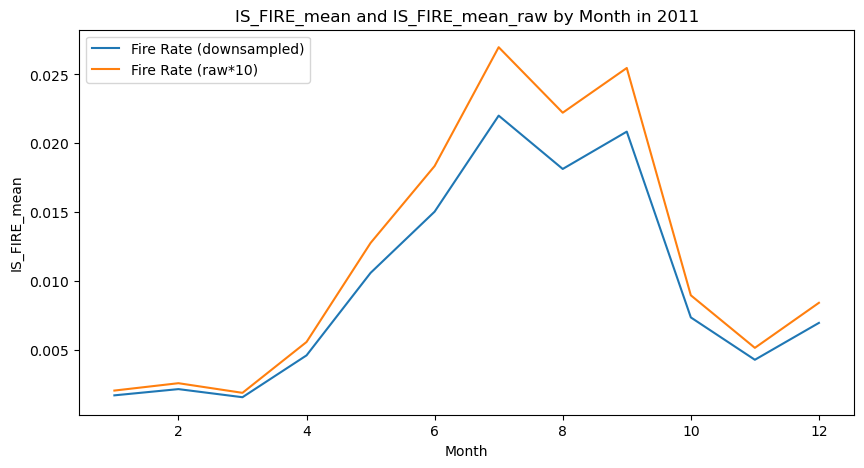

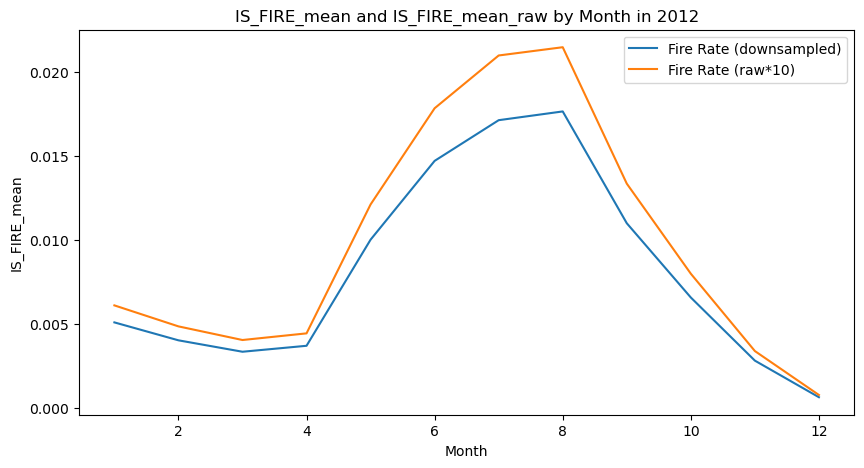

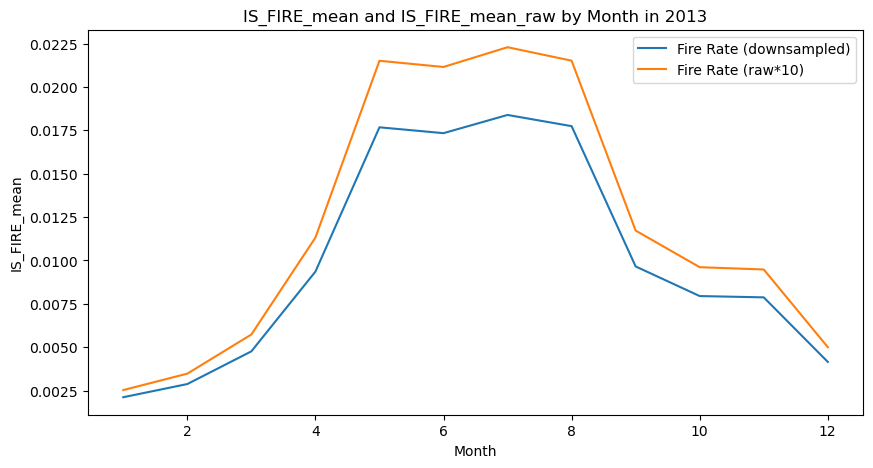

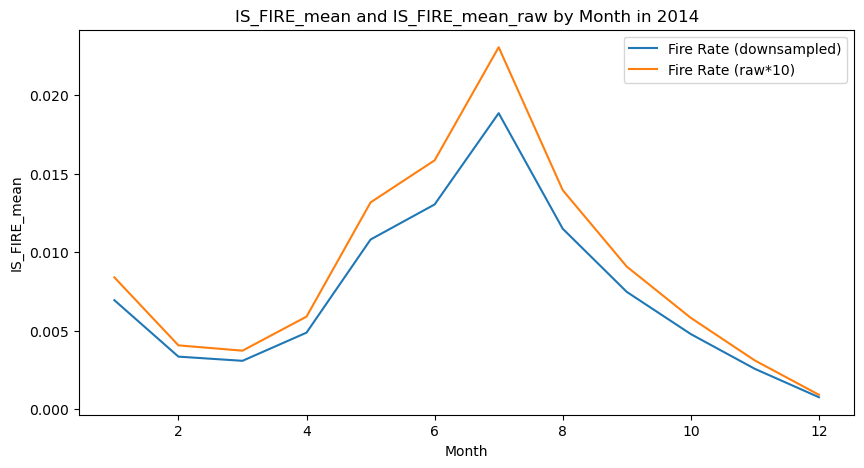

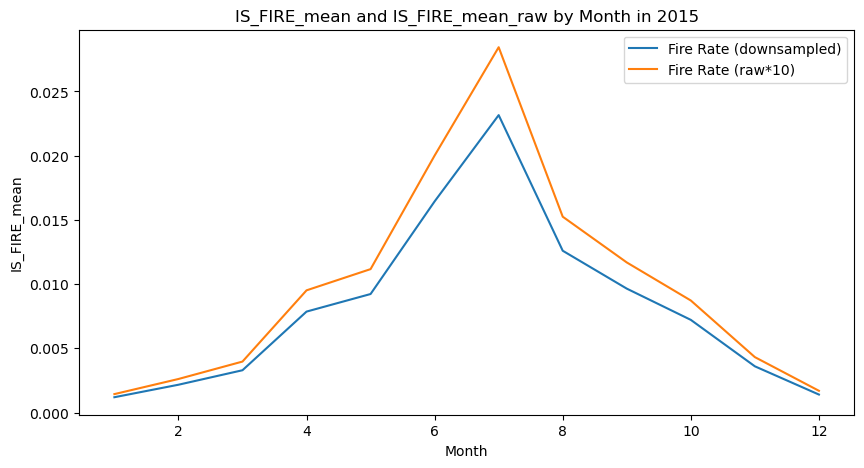

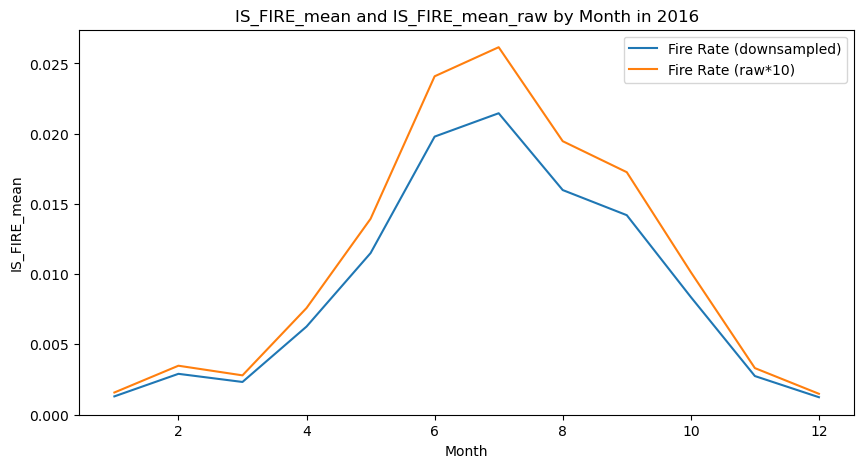

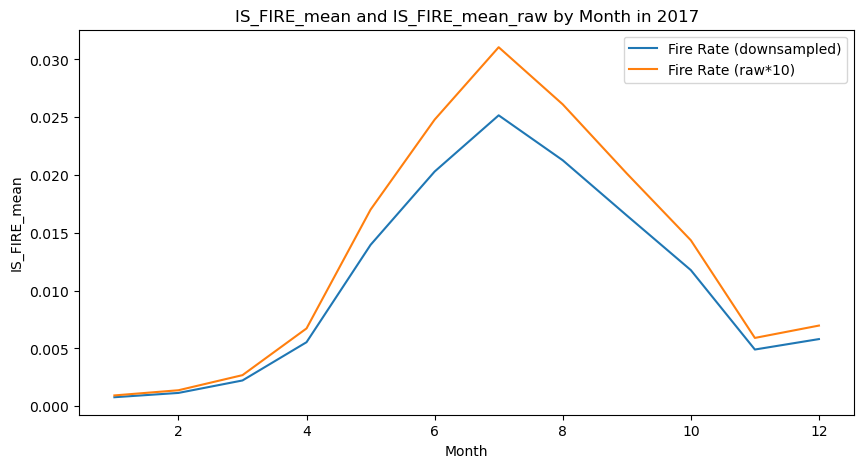

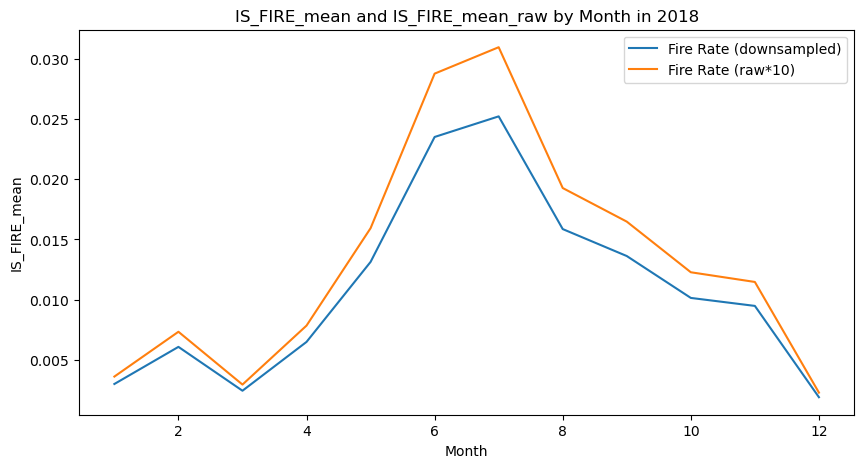

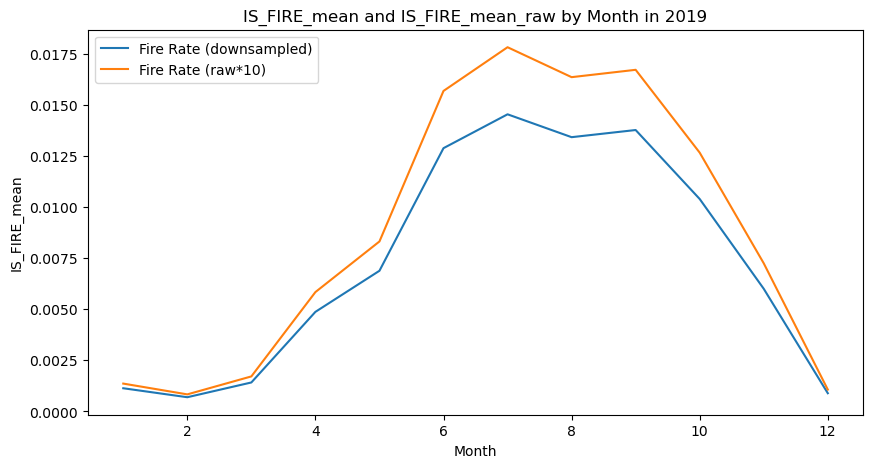

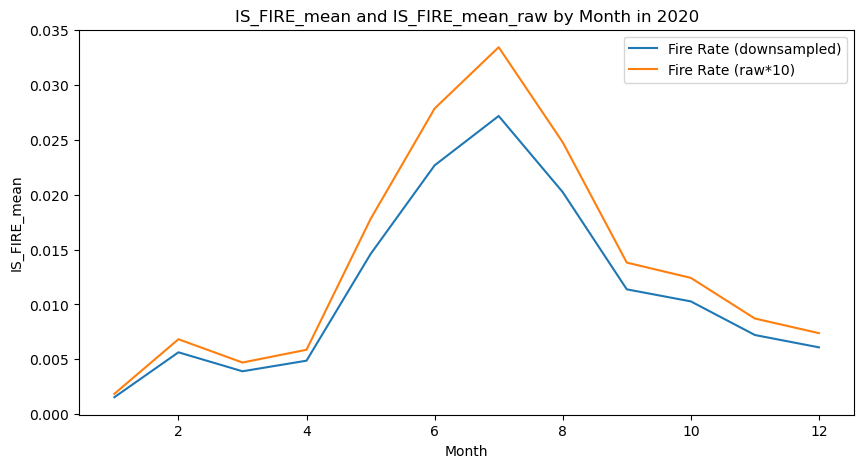

In [43]:
# Define the range of years
years = range(2007, 2021)

result_raw = pd.DataFrame()

for year in tqdm(years, desc="Processing years"):
    plot_fire_data(merge_data, year)